In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

import sys


sys.path.append('../..')

import optimneuralts
import viz_config


saves_path = '../saves'

In [26]:
n_dim = 25
n_trials = 5000
n_layers = 1
max_n_steps = 100
interval = 100
metrics_dict = {}
metrics = ['jaccards', 'ratio_app', 'ratio_found_existing_vecs_with_pats', 'ratio_found_pats', 'losses']
for metric in metrics:
    metrics_dict[metric] = []

for run in range(50):
    fn = f'd{n_dim}_trials{n_trials}_nlayers{n_layers}_max_n_steps_{max_n_steps}_run{run}.pth'
    for metric in metrics:
        path = f"{saves_path}/{metric}/{fn}"
        metrics_dict[metric].append(torch.load(path))



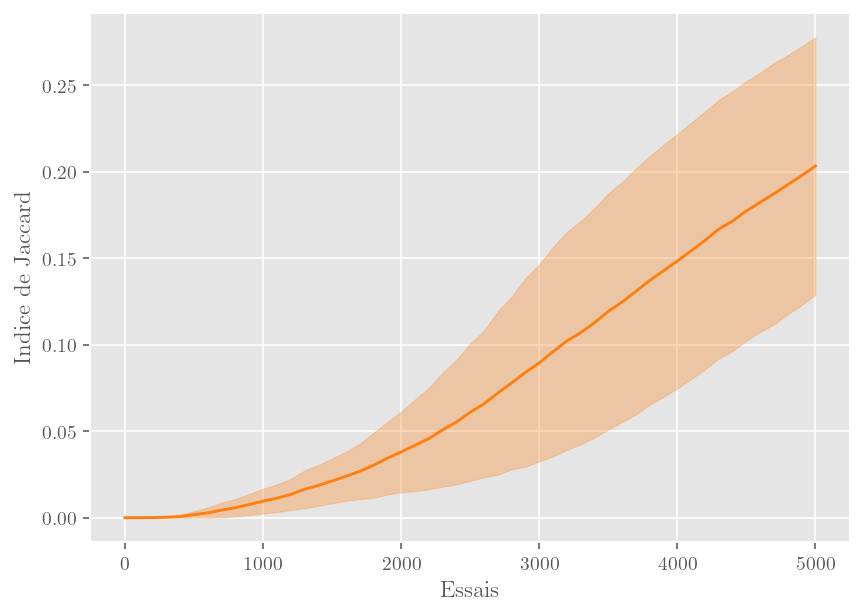

In [27]:
# Plot jaccards
metric = "jaccards"

x = list(range(0, n_trials + 100, interval))
means = np.nanmean(metrics_dict[metric], axis=0)
stds = np.nanstd(metrics_dict[metric], axis=0)

plt.plot(x, means, color='tab:orange')
plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color='tab:orange', alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Indice de Jaccard")
plt.savefig(f'../images/exp_poly/perf/{metric}_d{n_dim}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')

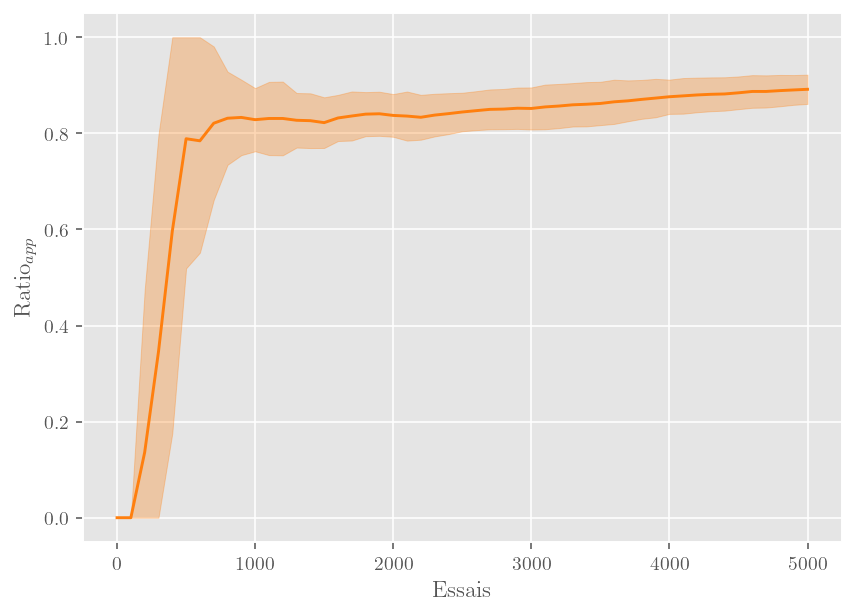

In [28]:
# Plot ratio app
metric = "ratio_app"

x = list(range(0, n_trials + 100, interval))
means = np.nanmean(metrics_dict[metric], axis=0)
stds = np.nanstd(metrics_dict[metric], axis=0)

plt.plot(x, means, color='tab:orange')
plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color='tab:orange', alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{app}$")
plt.savefig(f'../images/exp_poly/perf/{metric}_d{n_dim}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


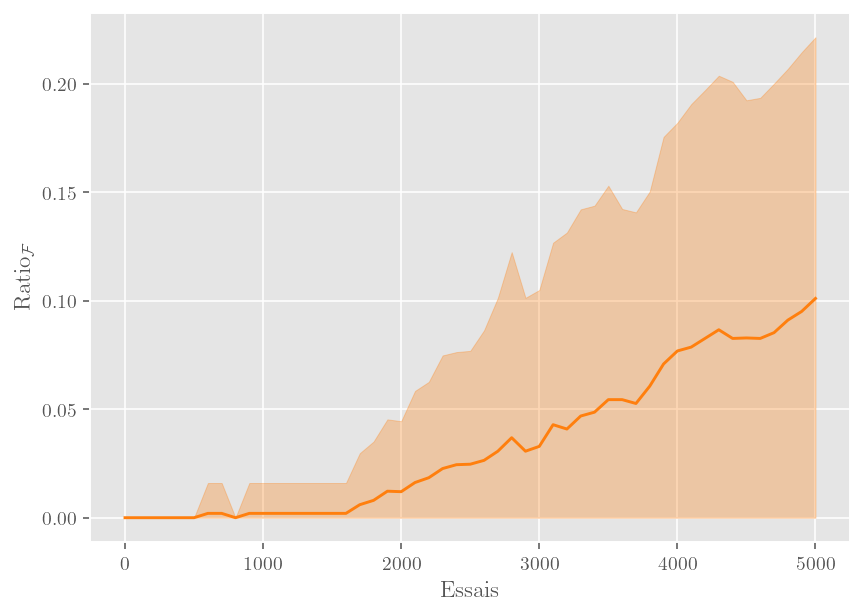

In [29]:
# Plot ratio found pat
metric = "ratio_found_pats"

x = list(range(0, n_trials + 100, interval))
means = np.nanmean(metrics_dict[metric], axis=0)
stds = np.nanstd(metrics_dict[metric], axis=0)

plt.plot(x, means, color='tab:orange')
plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color='tab:orange', alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{F}}$")
plt.savefig(f'../images/exp_poly/perf/{metric}_d{n_dim}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


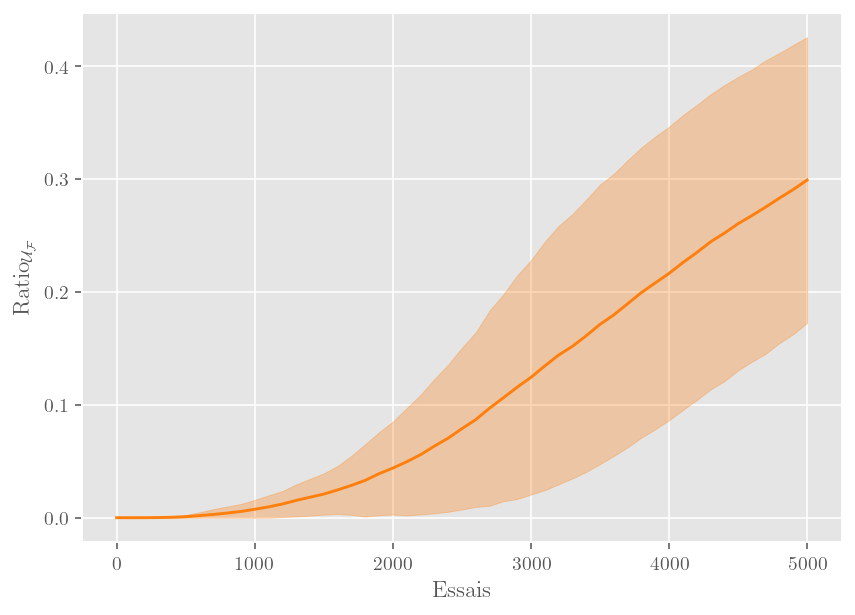

In [30]:
# Plot ratio found pat
metric = "ratio_found_existing_vecs_with_pats"

x = list(range(0, n_trials + 100, interval))
means = np.nanmean(metrics_dict[metric], axis=0)
stds = np.nanstd(metrics_dict[metric], axis=0)

plt.plot(x, means, color='tab:orange')
plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color='tab:orange', alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{U}_{\mathcal{F}}}$")
plt.savefig(f'../images/exp_poly/perf/{metric}_d{n_dim}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


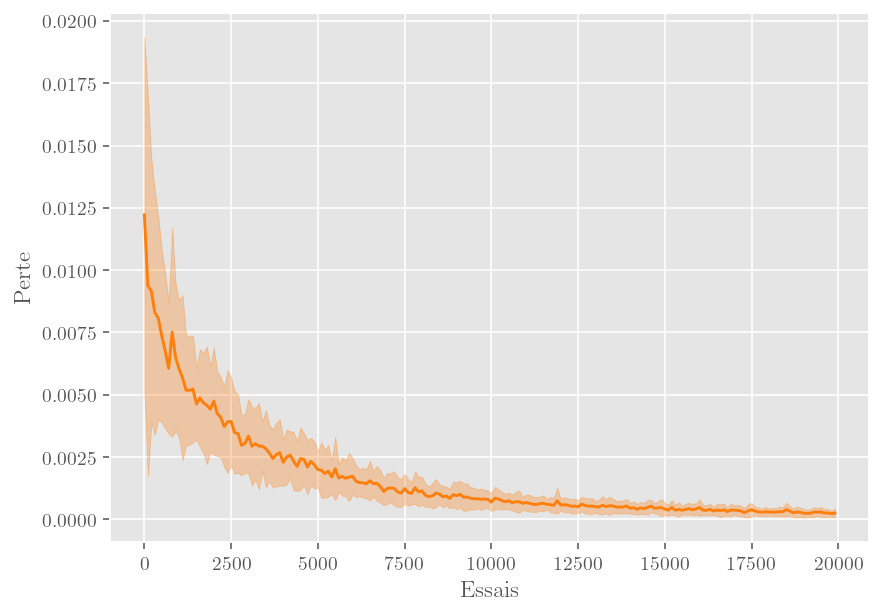

In [42]:
# Plot ratio found pat
metric = "losses"

x = list(range(0, n_trials, interval))
means = np.nanmean(metrics_dict[metric], axis=0)
stds = np.nanstd(metrics_dict[metric], axis=0)

plt.plot(x, means, color='tab:orange')
plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color='tab:orange', alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte")
plt.savefig(f'../images/exp_poly/perf/{metric}_d{n_dim}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


# Compare multiple dimension runs

In [3]:
# n_dims = ['1600', '1600_dense20', '1600_denser', '1600_denser_adam', '1600_dense500', '1600_densest']
# n_dims = ['1600_narrower', '1600_denser_narrower', '1600_dense500_narrower', '1600_densest_narrower']
# n_dims = ['1600_narrower', '1600_narrower_adam']
# n_dims = ['1600_narrower_adam', '1600_denser_narrower_adam', '1600_dense500_narrower_adam', '1600_densest_narrower_adam']
# n_dims = ['1600_wider', '1600_dense20_wider', '1600_denser_wider', '1600_dense500_wider', '1600_densest_wider']
n_dims = ['1600_perturbed', '1600_denser_perturbed', '1600_dense500_perturbed', '1600_densest_perturbed']
n_trials = 20000
n_layers = 1
max_n_steps = 100
interval = 100
metrics_dict = {}
# metrics = ['jaccards', 'ratio_app', 'ratio_found_existing_vecs_with_pats', 'ratio_found_pats', 'losses', "d_losses"]
metrics = ['jaccards', 'ratio_app', 'ratio_found_existing_vecs_with_pats', 'ratio_found_pats', 'losses', "d_losses"]
for d in n_dims:
    metrics_dict[d] = {}

    for metric in metrics:
        metrics_dict[d][metric] = []


for d in n_dims:
    for run in range(100):
        if 'dense' in d or 'perturbed' in d:
            actual_dim, dense_type = d.split('_', 1)
            fn = f'd{actual_dim}_trials{n_trials}_nlayers{n_layers}_max_n_steps_{max_n_steps}_run{run}_{dense_type}.pth'
        else:
            fn = f'd{d}_trials{n_trials}_nlayers{n_layers}_max_n_steps_{max_n_steps}_run{run}.pth'
        for metric in metrics:
            path = f"{saves_path}/{metric}/{fn}"
            try:
                list_ = torch.load(path)
                if type(list_[0]) == torch.Tensor:
                    x = lambda obj: obj.item()
                    list_ = list(map(x, list_))
                metrics_dict[d][metric].append(list_)
            except:
                print(f'failed to load {d} {metric}')
                pass



In [ ]:
# metrics_dict_ae = torch.load(f'{saves_path}/metrics_dict_start.pth')

# for algo in metrics_dict_ae.keys():
#     for metric in metrics_dict_ae[algo].keys():
#         metrics_dict_ae[algo][metric] = [np.append(metrics_dict_ae[algo][metric][i][::100], metrics_dict_ae[algo][metric][i][-1]) for i in range(50)]

# metrics_dict['25lin'] = metrics_dict_ae['all_init_end']

# metrics_dict['25lin']['ratio_app'] = metrics_dict['25lin']['percent_intersect']
# del metrics_dict['25lin']['percent_intersect']

# metrics_dict['25lin']['ratio_found_existing_vecs_with_pats'] = metrics_dict['25lin']['ratio_vecs_with_pattern_found']
# del metrics_dict['25lin']['ratio_vecs_with_pattern_found']

# metrics_dict['25lin']['ratio_found_pats'] = metrics_dict['25lin']['ratio_pattern_found']
# del metrics_dict['25lin']['ratio_pattern_found']


In [ ]:
# metrics_dict_ae = torch.load(f'{saves_path}/metrics_dict_ae.pth')

# for algo in metrics_dict_ae.keys():
#     for metric in metrics_dict_ae[algo].keys():
#         metrics_dict_ae[algo][metric] = [metrics_dict_ae[algo][metric][i][::20] for i in range(50)]


# metrics_dict['150lin'] = metrics_dict_ae['150']
# metrics_dict['150aelin'] = metrics_dict_ae['ae']

# metrics_dict['150lin']['ratio_app'] = metrics_dict['150lin']['percent_intersect']
# metrics_dict['150aelin']['ratio_app'] = metrics_dict['150aelin']['percent_intersect']
# del metrics_dict['150lin']['percent_intersect']
# del metrics_dict['150aelin']['percent_intersect']

# metrics_dict['150lin']['ratio_found_existing_vecs_with_pats'] = metrics_dict['150lin']['ratio_vecs_with_pattern_found']
# metrics_dict['150aelin']['ratio_found_existing_vecs_with_pats'] = metrics_dict['150aelin']['ratio_vecs_with_pattern_found']
# del metrics_dict['150lin']['ratio_vecs_with_pattern_found']
# del metrics_dict['150aelin']['ratio_vecs_with_pattern_found']

# metrics_dict['150lin']['ratio_found_pats'] = metrics_dict['150lin']['ratio_pattern_found']
# metrics_dict['150aelin']['ratio_found_pats'] = metrics_dict['150aelin']['ratio_pattern_found']
# del metrics_dict['150lin']['ratio_pattern_found']
# del metrics_dict['150aelin']['ratio_pattern_found']


In [24]:
colors = ['tab:orange', 'tab:purple', 'tab:green', 'tab:red', 'tab:cyan', 'tab:brown']
# labels = ['$d = 150$ (NeuralTS)', '$d = 550$ (NeuralTS)', '$d = 1600$ (NeuralTS)', '$d = 150$ (OptimLin(ST)$^2$)', '$d = 150$ (OptimLin(ST)$^2$ avec AE)']
# labels = ['$d = 25$ (NeuralTS)', '$d = 25$ (OptimLin(ST)$^2$, Debut/Fin)']

# labels = [r'densité $\approx$ 10', r'densité $\approx$ 20',r'densité $\approx$ 100',r'densité $\approx$ 100, Adam',r'densité $\approx$ 500', r'densité $\approx$ 1000']

# labels = [r'densité $\approx$ 10',r'densité $\approx$ 100', r'densité $\approx$ 500', r'densité $\approx$ 1000']
# labels = [r'densité $\approx$ 10 SGD',r'densité $\approx$ 10 Adam']

# labels = [r'$d = 1600$ (densité $\approx$ 10)', r'$d = 1600$ (densité $\approx$ 20)', r'$d = 1600$ (densité $\approx$ 100)', r'$d = 1600$ (densité $\approx$ 500)', r'$d = 1600$ (densité $\approx$ 1000)']

# labels = [r'$d = 1600$ (densité $\approx$ 10, 10 neurones)', r'$d = 1600$ (densité $\approx$ 20, 10 neurones)', r'$d = 1600$ (densité $\approx$ 100, 10 neurones)', r'$d = 1600$ (densité $\approx$ 500, 10 neurones)', r'$d = 1600$ (densité $\approx$ 1000, 10 neurones)']
labels = [r'$d = 1600$ (densité $\approx$ 10, 10 neurones)', r'$d = 1600$ (densité $\approx$ 100, 10 neurones)', r'$d = 1600$ (densité $\approx$ 500, 10 neurones)', r'$d = 1600$ (densité $\approx$ 1000, 10 neurones)']
# labels = [r'$d = 1600$ (densité $\approx$ 10, 10 neurones)', r'$d = 1600$ (densité $\approx$ 100, 10 neurones)', r'$d = 1600$ (densité $\approx$ 1000, 10 neurones)']
# labels = [r'$d = 1600$ (densité $\approx$ 10, 10 neurones)', r'$d = 1600$ (densité $\approx$ 100, 10 neurones)']
# labels = [r'$d = 1600$ (densité $\approx$ 10, 1000 neurones)', r'$d = 1600$ (densité $\approx$ 100, 1000 neurones)', r'$d = 1600$ (densité $\approx$ 1000, 1000 neurones)']

upper_lim = 10100

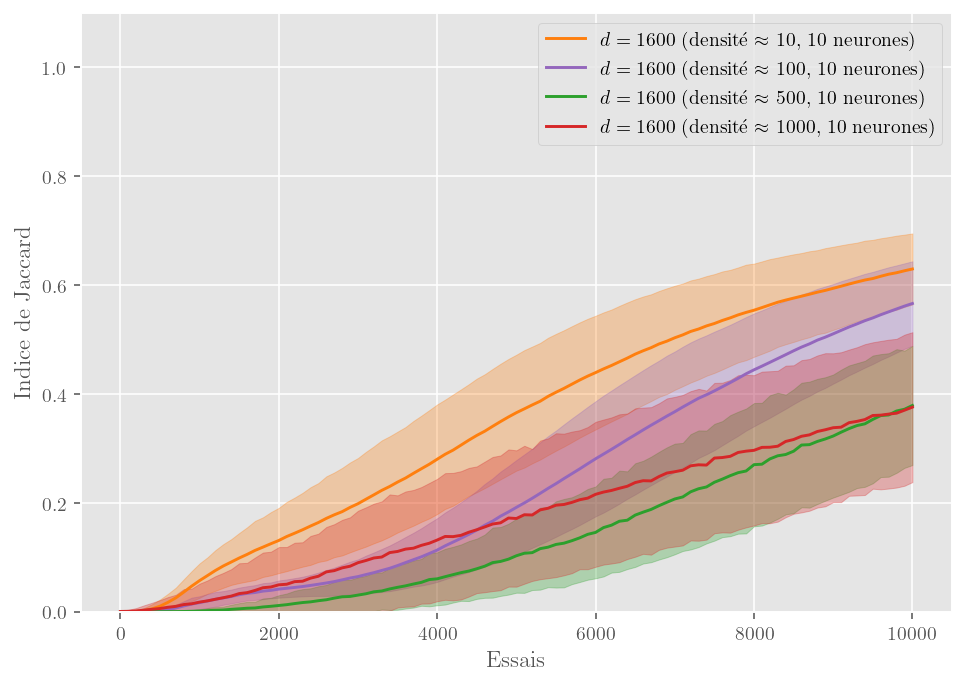

In [25]:
# Plot ratio found pat
metric = "jaccards"

for i, d in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
    plt.xlabel('Essais')
    plt.ylabel("Indice de Jaccard")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()

# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


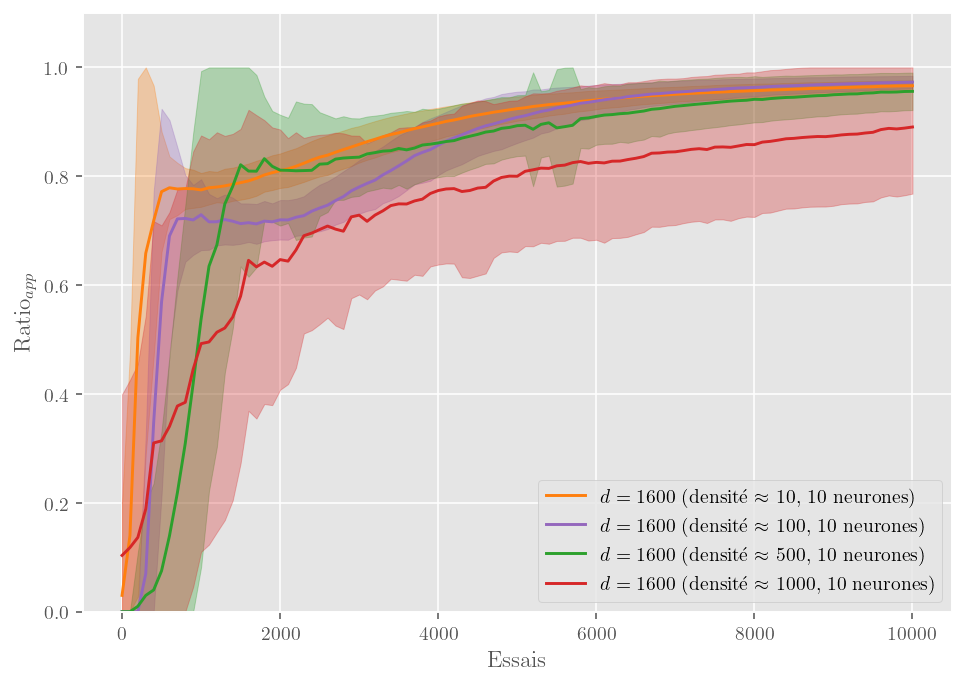

In [26]:
# Plot ratio found pat
metric = "ratio_app"

for i, d in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim// interval)]

    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
    plt.xlabel('Essais')
    plt.ylabel("Ratio$_{app}$")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()

# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')



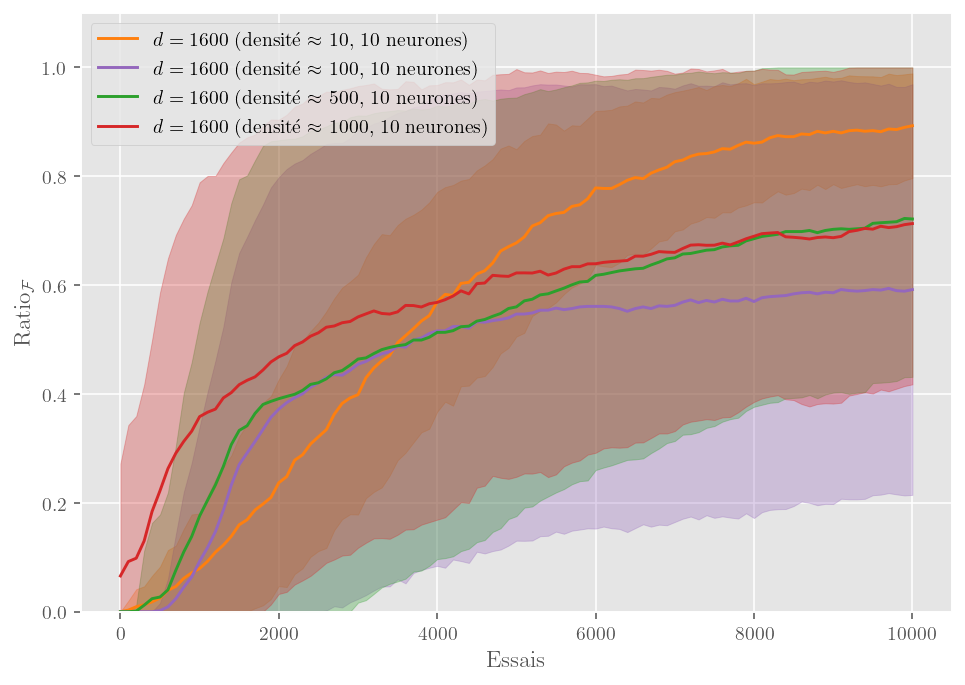

In [27]:
# Plot ratio found pat
metric = "ratio_found_pats"

for i, d in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{F}}$")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()


# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


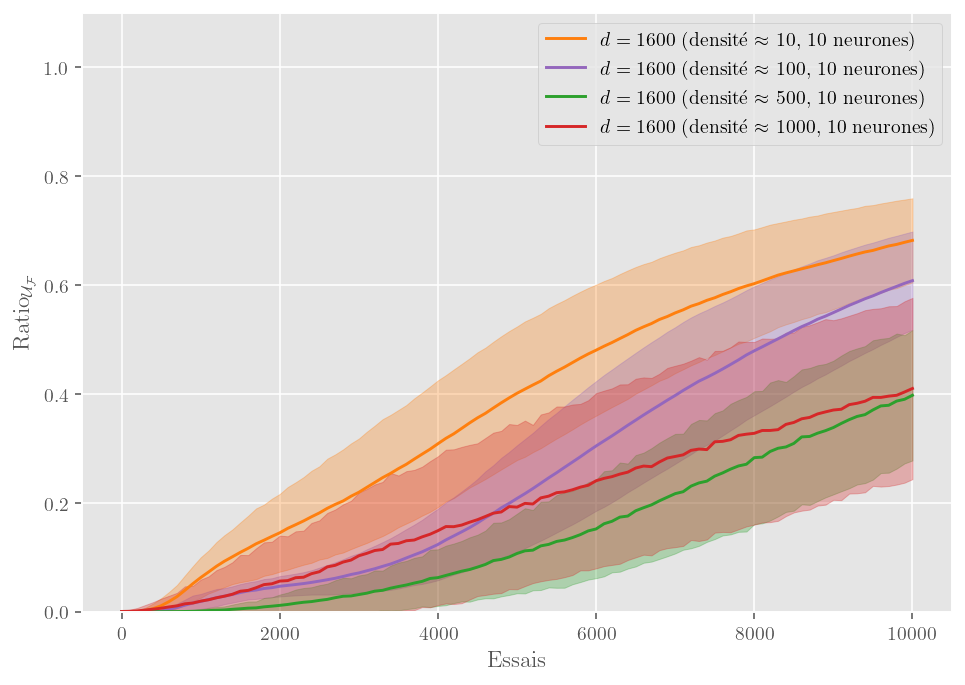

In [28]:
# Plot ratio found pat
metric = "ratio_found_existing_vecs_with_pats"

for i, d in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{U}_{\mathcal{F}}}$")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()


# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


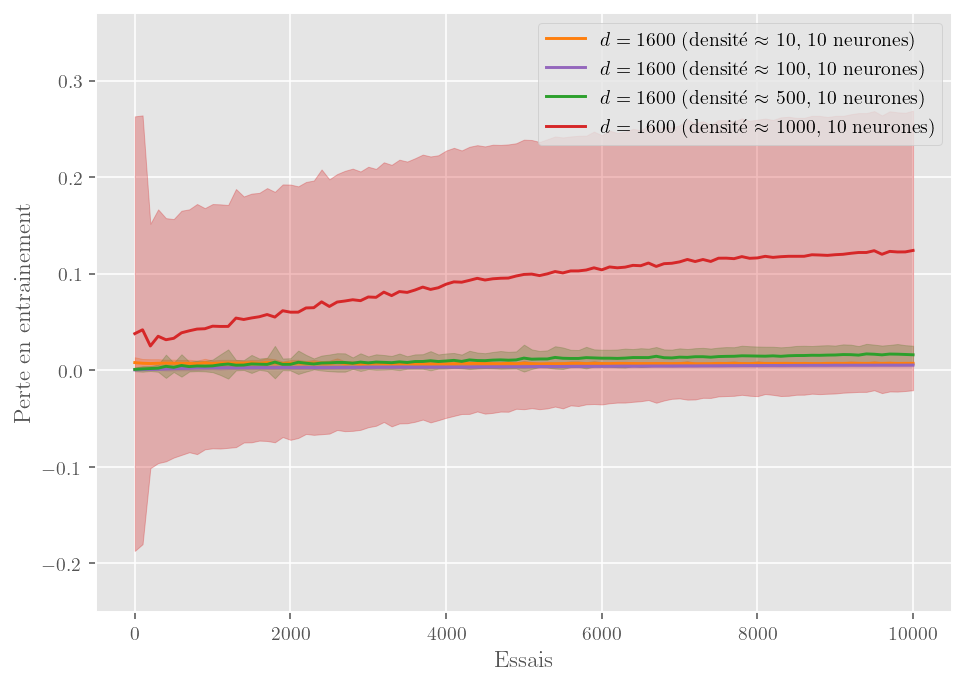

In [29]:
# Plot ratio found pat
metric = "losses"
for i, d in enumerate(n_dims):
    means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte en entrainement")
plt.ylim(-0.25, 0.37)
plt.legend()
plt.tight_layout()

# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')


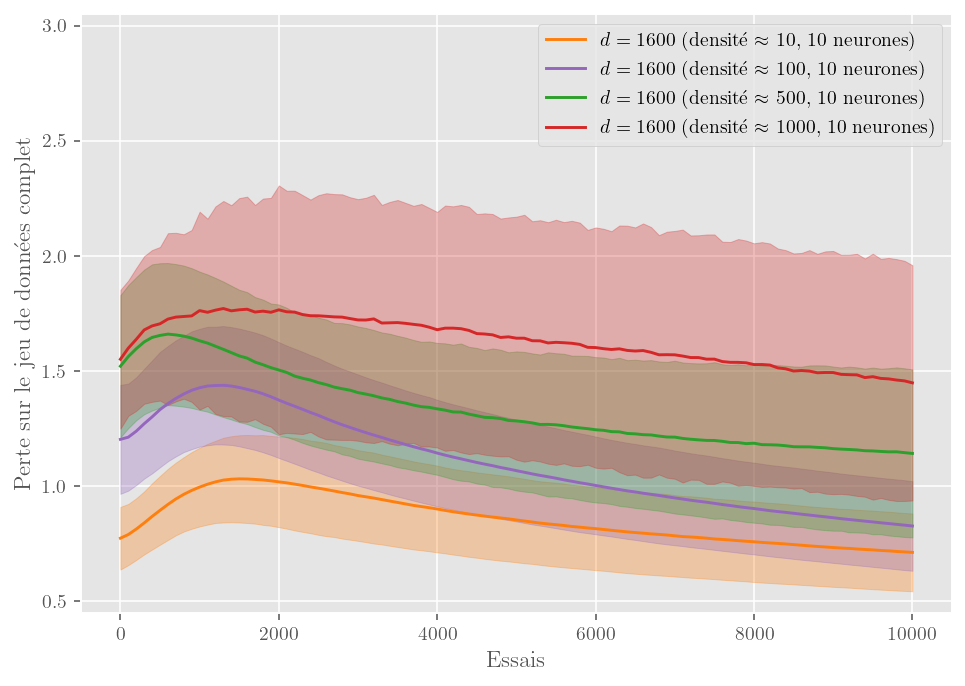

In [30]:
# Plot ratio found pat
metric = "d_losses"
# print(metrics_dict["d_losses"])
for i, d in enumerate(n_dims):
    try:
        means = np.nanmean(metrics_dict[d][metric], axis=0)[:(upper_lim // interval)]
        stds = np.nanstd(metrics_dict[d][metric], axis=0)[:(upper_lim// interval)]
        x = np.arange(len(means)) * interval

        plt.plot(x, means, color=colors[i], label=labels[i])
        plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
    except:
        pass
plt.xlabel('Essais')
plt.ylabel("Perte sur le jeu de données complet")
plt.legend()
plt.ylim(0.45, 3.05)
plt.tight_layout()
# plt.savefig(f'../images/exp_poly/perf/compare_highdim_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
# plt.savefig(f'../images/exp_poly/perf/compare_25lin_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')
plt.savefig(f'../images/exp_poly/perf/compare_density_{metric}_d{n_dims}_t{n_trials}_nlayers{n_layers}_steps{max_n_steps}')